# SLAB benchmark analysis


In this notebook, I retrieve the results from a [lkp-tests](https://github.com/intel/lkp-tests) benchmark and process the `slabinfo` file in it.

**NOTE:** `lkp-tests` only sampled from `/proc/slabinfo` and **not** from `/sys/kernel/slab/...`.
So I added a custom monitor to `lkp-tests` which gathers the data extracted by the [linux/tools/vm/slabinfo.c](https://github.com/torvalds/linux/blob/8a8c600de5dc1d9a7f4b83269fddc80ebd3dd045/tools/vm/slabinfo.c) tool.

**Benchmark name:** `fsmark-1hdd-1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M.yaml`

**NOTE:** The specs of the VM (used to run the benchmark) is attached at the end of this notebook.

## How the efficiency was calculated


The efficiency means how much space the used objects need in principle, divided by the real memory usage.

> efficiency_in_percent = (num_objs * objsize * 100) / (num_slabs * (page_size * 2 ** order))

The efficiency is calculated individually for each slab cache seperatedly in time.

Taken from [linux/tools/vm/slabinfo.c](https://github.com/torvalds/linux/blob/8a8c600de5dc1d9a7f4b83269fddc80ebd3dd045/tools/vm/slabinfo.c#L644)


## Install instructions

```bash
# or via ssh
git clone --depth 1 https://github.com/intel/lkp-tests

cd lkp-tests
# If this fails, try another OS
sudo make install

cd ..

# Adapt the lkp-tests/hosts/YOUR_HOSTNAME file to have a `hdd_partition` section
# You can use the `create-block-device.sh` script provided in the root of this repository 

# This MUST be done after EVERY change to the "lkp-tests/hosts/YOUR_HOSTNAME" file!
lkp split lkp-tests/jobs/fsmark-1hdd.yaml

sudo lkp install fsmark-1hdd-1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M.yaml
sudo lkp run fsmark-1hdd-1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M.yaml
```

In [40]:
# Convert this notebook
!jupyter nbconvert --to rst process.ipynb

[NbConvertApp] Converting notebook process.ipynb to rst
[NbConvertApp] Support files will be in process_files/
[NbConvertApp] Making directory process_files
[NbConvertApp] Making directory process_files
[NbConvertApp] Making directory process_files
[NbConvertApp] Making directory process_files
[NbConvertApp] Making directory process_files
[NbConvertApp] Writing 18528 bytes to process.rst


## Retrieve lkp-tests result folder from VM

In [2]:
HOST="david-vm-ubuntu"
TIMESTAMP = !date +%s
!mkdir -p results
!ssh {HOST} 'cd projects; echo "a" | sudo -S ./save_slab_orders.sh'
!scp -r -q {HOST}:projects/result results/result_{TIMESTAMP}
!ssh {HOST} 'ls -l projects/result | cut -d ">" -f 2' > results/result_{TIMESTAMP}/job

[sudo] password for vm: 

### Setup visualizations

In [12]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sns.set_style('whitegrid')

matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

## Parse results

In [45]:
import os
from glob import glob
FOLDER = sorted(glob('results/result_*'))[0]
IMAGE_FOLDER = 'images'

os.makedirs(IMAGE_FOLDER, exist_ok=True)

with open(FOLDER + '/job') as f:
    job_name = f.read().strip()

with open(FOLDER + '/slabinfo') as f:
    slab_info = f.read().splitlines()

with open(FOLDER + '/slabinfo_tool') as f:
    slab_info_tool = f.read().splitlines()

with open(FOLDER + '/orders') as f:
    orders = {x.split()[0]: int(x.split()[1]) for x in f.readlines()}

def convert_num(x):
    try:
        return int(x)
    except:
        return x

def parse_slabinfo_log(lkp_tests_slab_info):
    data = []
    current = None
    
    for line in lkp_tests_slab_info:
        if line.startswith('time:'):
            current = int(line.split()[-1])
            continue

        l = [current] + [convert_num(x.strip()) for x in line.split() if x is not ':']

        data.append(l)
    return data

job_name

'/lkp/result/fsmark/1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M/david-vm-ubuntu/ubuntu/x86_64-rhel-7.6/gcc-7/5.0.0-31-generic/12'

## slabinfo tool

See [slabinfo.c](https://github.com/torvalds/linux/blob/8a8c600de5dc1d9a7f4b83269fddc80ebd3dd045/tools/vm/slabinfo.c#L644) for more information.

The tool uses `/sys/kernel/slab/...` and **NOT** `/proc/slabinfo`.

In [46]:
import pandas as pd

# Headers taken from output of `slabinfo`
SLABINFO_TOOL_HEADERS = [
    'time', # added
    'name',
    'objects',
    'object_size',
    'space',
    'slabs_part_cpu',
    'o_s',
    'o',
    'percent_free',
    'percent_efficient',
    'flags'
]

df_slabinfo_tool = pd.DataFrame(
    # Ignore header
    [x for x in parse_slabinfo_log(slab_info_tool) if not x[1].startswith('Name')],
    columns = SLABINFO_TOOL_HEADERS
)

# Filter out "filp" cache which has a efficiency above 100%?
df_slabinfo_tool = df_slabinfo_tool[df_slabinfo_tool.percent_efficient <= 100]

# Converts the '10.9K' and '10.1M' space notation to numbers (Kb)
def normalize_space(x):
    num = float(x[:-1])
    if x.endswith('M'):
        num = num * 1024
    return num

df_slabinfo_tool['space_normalized_in_kb'] = df_slabinfo_tool.space.apply(normalize_space)
# Check that the only suffixes are 'K' (kilo) and 'M' (mega)
for idx, x in df_slabinfo_tool.space.iteritems():
    assert(x.endswith('K') or x.endswith('M'))

### Plot efficiency (histogram) 

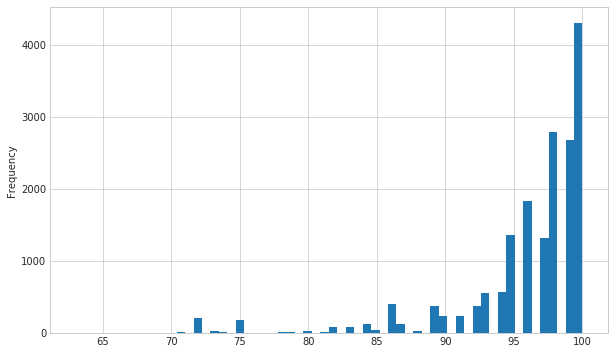

In [47]:
df_slabinfo_tool.percent_efficient.plot(kind='hist', bins=60)

### Plot efficiency (timeline)

Text(0.5,1,'Average SLAB efficiency over time')

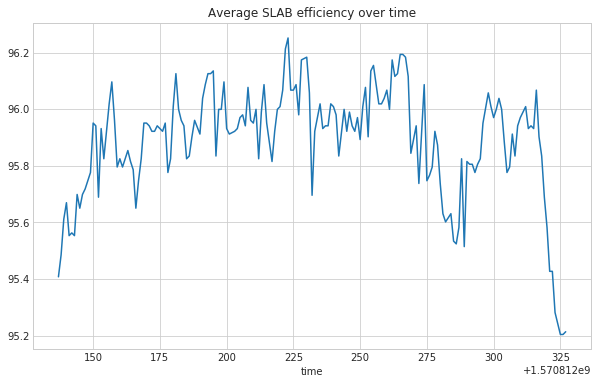

In [48]:
ax = df_slabinfo_tool.groupby('time').percent_efficient.mean().plot()
ax.set_title('Average SLAB efficiency over time')

### Calculate and plot weighted efficiency (timeline)

The weighted efficiency takes the size of the cache into consideration

Text(0.5,1,'Weighted average SLAB efficiency over time')

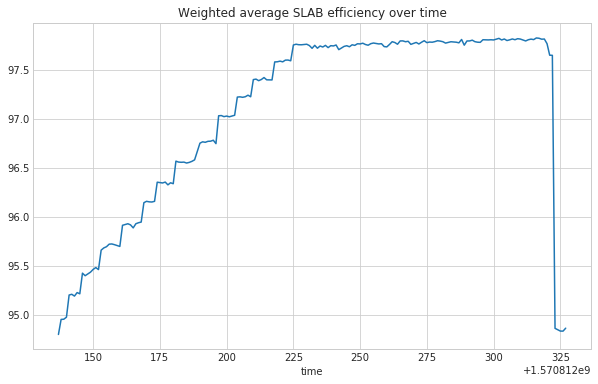

In [49]:
import numpy as np

# Taken from: https://stackoverflow.com/a/33054358
weighted_average_efficiency = df_slabinfo_tool.groupby('time').apply(lambda x: np.average(x.percent_efficient, weights=x.space_normalized_in_kb))
ax = weighted_average_efficiency.plot()
ax.set_title('Weighted average SLAB efficiency over time')

### Plot efficiency of specific cache (dentry)

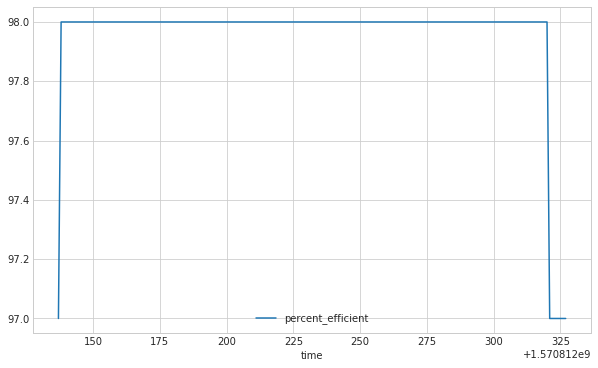

In [50]:
dentries = df_slabinfo_tool[df_slabinfo_tool.name == 'dentry']
dentries.plot(x='time', y='percent_efficient')

### Most unefficient cache 

Get most unefficient cache - averaged over time.

In [51]:
caches_sorted_by_efficiency = df_slabinfo_tool.groupby('name').mean().sort_values('percent_efficient')
caches_sorted_by_efficiency[['percent_efficient', 'space_normalized_in_kb']].head(30)

,percent_efficient,space_normalized_in_kb
name,,
skbuff_head_cache,72.000000,98.300000
scsi_sense_cache,75.000000,20.400000
kmalloc-96,78.903955,391.393220
names_cache,82.033898,442.582486
:a-0000256,82.706215,102.264407
task_struct,83.785311,3890.621469
:0000320,86.000000,368.600000
cred_jar,86.000000,278.453672
anon_vma,88.649718,824.288701


## /proc/slabinfo

**Not to be confused with the output of the `slabinfo` tool!**

### Create visualizations

Test took: 3.17 minutes


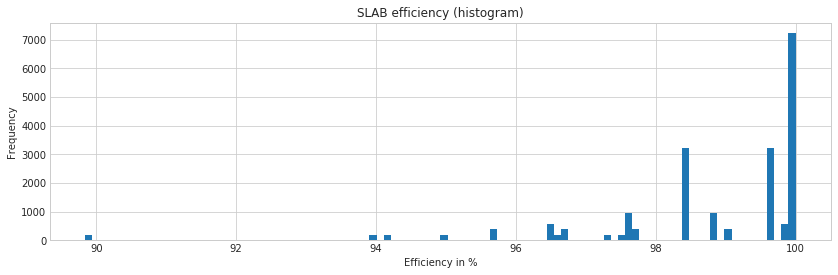

In [25]:
# Extracted from `/proc/slabinfo`
headers = [
    'time',
    'name',
    'active_objs',
    'num_objs',
    'objsize',
    'objperslab',
    'pagesperslab',
    'tunables',
    'limit',
    'batchcount',
    'sharedfactor',
    'slabdata',
    'active_slabs',
    'num_slabs',
    'sharedavail',
]
data = parse_slabinfo_log(slab_info)

data = [x for x in data if not x[1].startswith('# name') and not x[1].startswith('slabinfo')]

# Sanity check!
for l in data: assert len(l) == len(headers)

df = pd.DataFrame(data, columns=headers)

#df = df[df.name == 'dentry']

df['order'] = df.name.apply(lambda x: orders.get(x, 0))
df['page_size'] = 4096

df['active_vs_num'] = df.active_objs / df.num_objs

df['ef'] = df.num_objs * df.objsize * 100 / (df.num_slabs * (df.page_size * 2 ** df.order))

ax = df.ef.plot(kind='hist', bins=100, figsize=(14, 4))

ax.set_title(f'SLAB efficiency (histogram)')
ax.set_xlabel('Efficiency in %')

def sanitize_name(x):
    return x.replace('/', '___')

plt.savefig(f'{IMAGE_FOLDER}/{sanitize_name(job_name)}.png')

duration_in_seconds = max(df.time.values) - min(df.time.values)
print(f'Test took: {duration_in_seconds / 60:.2f} minutes')

## VM specs

**uname -a**: Linux david-vm-ubuntu 5.0.0-31-generic #33~18.04.1-Ubuntu SMP Tue Oct 1 10:20:39 UTC 2019 x86_64 x86_64 x86_64 GNU/Linux

<pre>
Name:                        Ubuntu
Groups:                      /
Guest OS:                    Ubuntu (64-bit)
UUID:                        517d91b9-e324-470f-b1f3-dcaf40f3ab01
Config file:                 /home/dgengenbach/VirtualBox VMs/Ubuntu/Ubuntu.vbox
Snapshot folder:             /home/dgengenbach/VirtualBox VMs/Ubuntu/Snapshots
Log folder:                  /home/dgengenbach/VirtualBox VMs/Ubuntu/Logs
Hardware UUID:               517d91b9-e324-470f-b1f3-dcaf40f3ab01
Memory size                  16384MB
Page Fusion:                 disabled
VRAM size:                   16MB
CPU exec cap:                100%
HPET:                        disabled
CPUProfile:                  host
Chipset:                     piix3
Firmware:                    BIOS
Number of CPUs:              4
PAE:                         disabled
Long Mode:                   enabled
Triple Fault Reset:          disabled
APIC:                        enabled
X2APIC:                      enabled
Nested VT-x/AMD-V:           disabled
CPUID Portability Level:     0
CPUID overrides:             None
Boot menu mode:              message and menu
Boot Device 1:               Floppy
Boot Device 2:               DVD
Boot Device 3:               HardDisk
Boot Device 4:               Not Assigned
ACPI:                        enabled
IOAPIC:                      enabled
BIOS APIC mode:              APIC
Time offset:                 0ms
RTC:                         UTC
Hardw. virt.ext:             enabled
Nested Paging:               enabled
Large Pages:                 disabled
VT-x VPID:                   enabled
VT-x unr. exec.:             enabled
Paravirt. Provider:          Default
Effective Paravirt. Prov.:   KVM
State:                       running (since 2019-10-10T10:10:24.186000000)
Monitor count:               1
3D Acceleration:             disabled
2D Video Acceleration:       disabled
Teleporter Enabled:          disabled
Teleporter Port:             0
Teleporter Address:          
Teleporter Password:         
Tracing Enabled:             disabled
Allow Tracing to Access VM:  disabled
Tracing Configuration:       
Autostart Enabled:           disabled
Autostart Delay:             0
Default Frontend:            
Storage Controller Name (0):            IDE
Storage Controller Type (0):            PIIX4
Storage Controller Instance Number (0): 0
Storage Controller Max Port Count (0):  2
Storage Controller Port Count (0):      2
Storage Controller Bootable (0):        on
Storage Controller Name (1):            SATA
Storage Controller Type (1):            IntelAhci
Storage Controller Instance Number (1): 0
Storage Controller Max Port Count (1):  30
Storage Controller Port Count (1):      1
Storage Controller Bootable (1):        on
IDE (1, 0): Empty
SATA (0, 0): /home/dgengenbach/VirtualBox VMs/Ubuntu/Ubuntu.vdi (UUID: 466e9eb9-b4f4-4088-9a6f-fc60775b5c8c)
NIC 1:                       MAC: 080027CA5503, Attachment: Bridged Interface 'eno1', Cable connected: on, Trace: off (file: none), Type: 82540EM, Reported speed: 0 Mbps, Boot priority: 0, Promisc Policy: deny, Bandwidth group: none
NIC 2:                       disabled
NIC 3:                       disabled
NIC 4:                       disabled
NIC 5:                       disabled
NIC 6:                       disabled
NIC 7:                       disabled
NIC 8:                       disabled
Pointing Device:             USB Tablet
Keyboard Device:             PS/2 Keyboard
UART 1:                      disabled
UART 2:                      disabled
UART 3:                      disabled
UART 4:                      disabled
LPT 1:                       disabled
LPT 2:                       disabled
Audio:                       enabled (Driver: PulseAudio, Controller: AC97, Codec: AD1980)
Audio playback:              enabled
Audio capture:               disabled
Clipboard Mode:              disabled
Drag and drop Mode:          disabled
Session name:                headless
Video mode:                  800x600x32 at 0,0 enabled
VRDE:                        disabled
OHCI USB:                    enabled
EHCI USB:                    disabled
xHCI USB:                    disabled

USB Device Filters:

<none>

Available remote USB devices:

<none>

Currently Attached USB Devices:

<none>

Bandwidth groups:  <none>

Shared folders:<none>

VRDE Connection:             not active
Clients so far:              0

Capturing:                   not active
Capture audio:               not active
Capture screens:             0
Capture file:                /home/dgengenbach/VirtualBox VMs/Ubuntu/Ubuntu.webm
Capture dimensions:          1024x768
Capture rate:                512kbps
Capture FPS:                 25kbps
Capture options:             

Guest:

Configured memory balloon size: 0MB
OS type:                     Linux26_64
Additions run level:         1
Additions version            6.0.6_KernelUbuntu r129722

Guest Facilities:

Facility "VirtualBox Base Driver": active/running (last update: 2019/10/10 10:10:31 UTC)
Facility "Seamless Mode": not active (last update: 2019/10/10 10:10:31 UTC)
Facility "Graphics Mode": not active (last update: 2019/10/10 10:10:31 UTC)
</pre>